In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as ss

In [2]:
active_studs = pd.read_csv('Проект_2_active_studs.csv')
checks = pd.read_csv('Проект_2_checks.csv', sep = ';')
group_add = pd.read_csv('Проект_2_group_add.csv')
groups = pd.read_csv('Проект_2_groups.csv', sep = ';')

In [3]:
#Для начала объединю таблицу с группами пользователей с дополнительными группами, которые были присланы позже

group_final = pd.concat([groups, group_add], ignore_index = True)

In [4]:
group_final.id.nunique()

74576

In [5]:
groups.id.nunique() + group_add.id.nunique()

# Дополнительно на всякий случай проверяю, не возникло ли от добавления дубликатов

74576

In [6]:
#Отсеиваю тех пользователей, что не проявляли активности в выбранный период

active_in_group = active_studs.merge(group_final, how = 'left', left_on = 'student_id', right_on = 'id')

In [7]:
#Удаляю ненужный столбец

active_in_group = active_in_group.drop('id', axis = 1)

In [8]:
#На всякий случай еще раз провожу проверку, что потерь id не произошло. Число совпало, значит, на данном этапе проблем быть не должно

active_studs.student_id.nunique()

8341

In [14]:
#Так как для каждого пользователя нам дали общую выручку, а не список операций, то мы можем просто объединить таблицы

full_df = active_in_group.merge(checks, on = 'student_id',how = 'left')

In [9]:
#Проверяю, есть ли пользователи, которые совершали покупки, но при этом не числяться активными. Таковые имеются, так что сохраняю их в отдельной таблице

extra_users = checks[~checks.student_id.isin(active_in_group.student_id)]

In [10]:
#Добавляю для новой таблицы данные о группе пользователя и переименовываю столбец

extra_users = extra_users.merge(group_final, how = 'left', left_on = 'student_id', right_on = 'id')

In [13]:
#Удаляю ненужный столбец

extra_users = extra_users.drop('id', axis = 1)

In [15]:
#Объединяю таблицы для получения полных данных

full_df = pd.concat([full_df, extra_users], ignore_index = True)

In [16]:
#Заменяю NaN на 0, так как для рассчетов мне это будет более удобно

full_df.rev = full_df.rev.fillna(0)

In [36]:
full_df

,student_id,grp,rev,customer
0,581585,A,0.0,0
1,5723133,A,0.0,0
2,3276743,B,0.0,0
3,4238589,A,0.0,0
4,4475369,B,0.0,0
...,...,...,...,...
8485,5291900,B,199.0,1
8486,5331842,B,290.0,1
8487,5486319,B,199.0,1
8488,5562806,B,398.0,1


# Анализ 1. Сравнение среднего чека у контрольной и тестовой групп (ARPPU)

В случае, если будет обнаружено статистически значимое увеличение среднего чека, то обновление может иметь смысл произвести.

In [18]:
#Для начала оставлю только тех пользователей, что совершали покупки, дабы проанализировать средний чек у тех, что что-либо купил

full_df_cust = full_df.query('rev > 0')

Text(0, 0.5, 'Число людей \n')

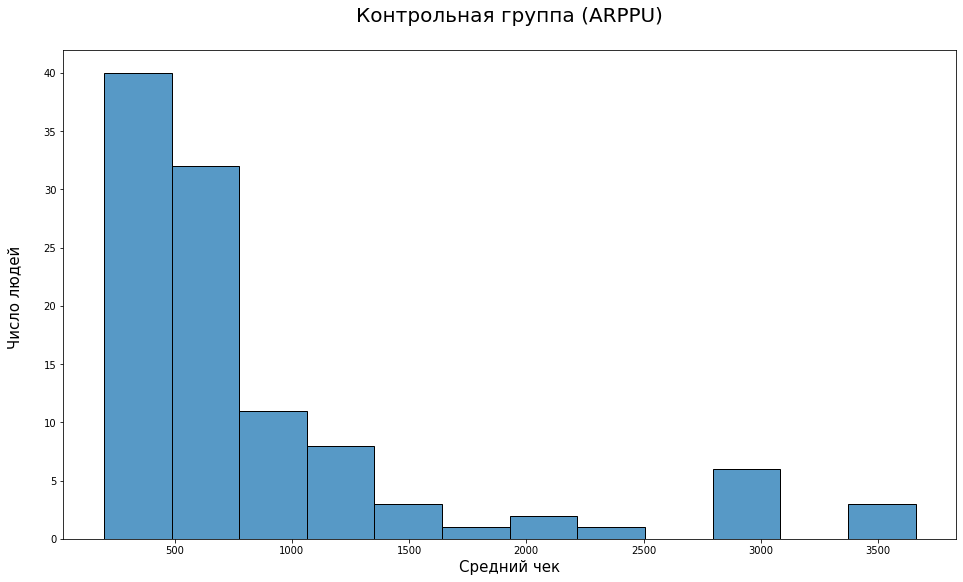

In [73]:
#Проверю распределение на нормальность

plt.figure(figsize = (16,9))

sns.histplot(data = full_df_cust.query('grp == "A"'), x = 'rev')

plt.title('Контрольная группа (ARPPU)\n', size = 20)
plt.xlabel('Средний чек', size = 15)
plt.ylabel('Число людей \n', size = 15)

Text(0, 0.5, 'Число людей \n')

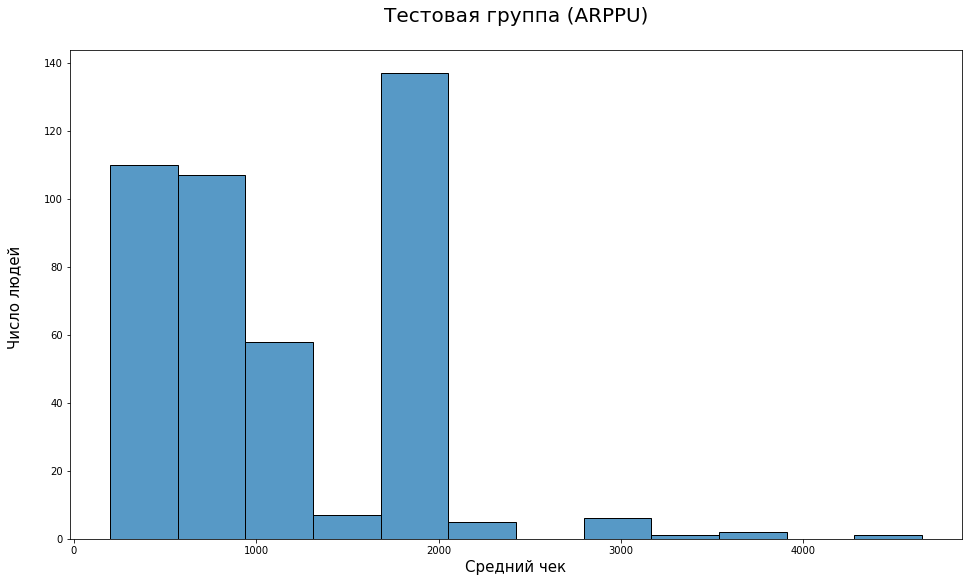

In [74]:
plt.figure(figsize = (16,9))

sns.histplot(data = full_df_cust.query('grp == "B"'), x = 'rev')

plt.title('Тестовая группа (ARPPU)\n', size = 20)
plt.xlabel('Средний чек', size = 15)
plt.ylabel('Число людей \n', size = 15)

In [23]:
#Проверяю равенство дисперсий

stat, p_value = ss.levene(full_df_cust.query('grp == "A"').rev, full_df_cust.query('grp == "B"').rev)

In [24]:
alpha = 0.05
if p_value < alpha:
    print("Отвергаем нулевую гипотезу: дисперсии не равны.")
else:
    print("Не отвергаем нулевую гипотезу: дисперсии равны.")

Отвергаем нулевую гипотезу: дисперсии не равны.


Распределения, что логично, строго не нормальны, а дисперсии не равны. В таком случае не получится проверять разницу среднего, а необходимо сравнить медианы

***Нулевая гипотеза***: медиана в контрольной и тестовой группе не отличаются друг от друга

In [25]:
#Проверяю наличие различий в медиане

control_mean = full_df_cust.query('grp == "A"').rev.median()
test_mean = full_df_cust.query('grp == "B"').rev.median()

print(f'Медианное значение чека в контрольной группе - {control_mean}, в тестовой - {test_mean}')

Среднее значение чека в контрольной группе - 690.0, в тестовой - 935.0


Наблюдается сильное различие в размере среднего чека. Осталось подтвердить (или опровергнуть) статистическую значимость этих значений

In [26]:
stat, p = ss.mannwhitneyu(full_df_cust.query('grp == "A"').rev, full_df_cust.query('grp == "B"').rev)

In [28]:
#Интерпертирую результаты

alpha = 0.05
if p < alpha:
    print('Различия медиан статистически значимы')
else:
    print('Различия медиан статистически не значимы') 

Различия медиан статистически значимы


Таким образом, по критерию величины среднего чека было выявлено статистически значимое увеличение, что может подтвердить целесообразность нововведения

# Анализ 2. Доля пользователей, совершивших покупки

Имеет основания полагать, что при усовершенствованной системе оплаты товаров будет гораздо чаще производиться конвертация из посетителя в покупателя. Проверим эту гипотезу

In [29]:
#Добавим к изначальной таблице столбец "покупатель", где 1 - потратил какую-то часть денег, 2 - не потратил ничего

full_df['customer'] = full_df.rev.apply(lambda x: 1 if x > 0 else 0)

In [30]:
#Так как здесь используется 2 категориальные переменные, использую критерий Хи-квадрат. Создаю кросстаб

pd.crosstab(full_df.customer, full_df.grp)

grp,A,B
customer,,
0,1460,6489
1,107,434


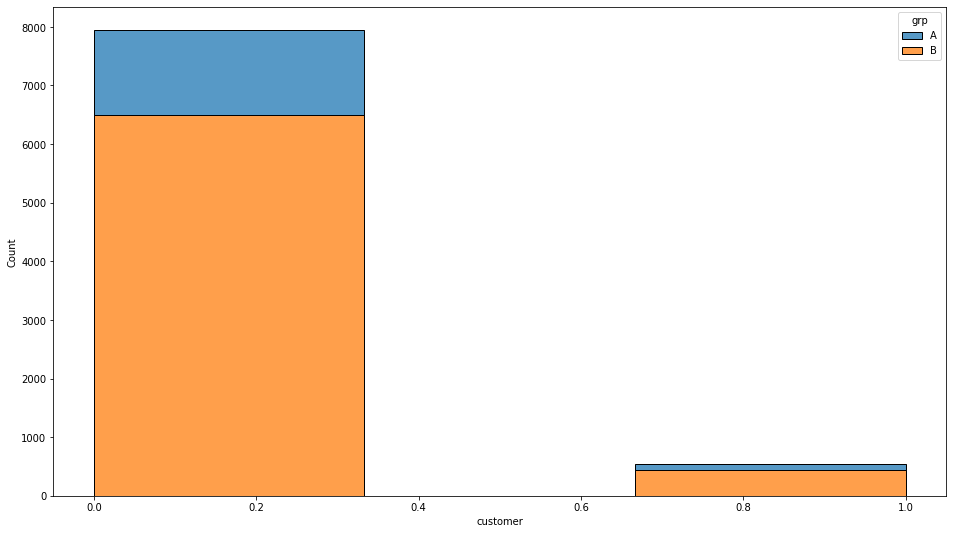

In [31]:
plt.figure(figsize = (16,9))

sns.histplot(data = full_df, x = 'customer', hue = 'grp', multiple = 'stack', bins = 3)

In [32]:
cancel_control = full_df.query('customer == 1 & grp == "A"').student_id.count() / full_df.query('grp == "A"').student_id.count() * 100
cancel_test = full_df.query('customer == 1 & grp == "B"').student_id.count() / full_df.query('grp == "B"').student_id.count() * 100

print(f'Доля отмененных заказов в контрольной группе - {cancel_control}%, в тестовой - {cancel_test}%')

Доля отмененных заказов в контрольной группе - 6.828334396936822%, в тестовой - 6.268958543983821%


Видим снижение конверсии пользователя в покупателя. Проверим, является ли оно статистически значимым

In [33]:
stat, prob, dof, expected = ss.chi2_contingency(pd.crosstab(full_df.customer, full_df.grp))

In [34]:
#Интерпретация результатов

if prob <= alpha:
    print('Взаимосвязь статистически значима')
else:
    print('Взаимосвязь статистически не значима')

Взаимосвязь статистически не значима


Статистическая значимость снижения конверсии не была обнаружена, следовательно, мы не может отвергать нулевую гипотезу

# Анализ 3. Суммарная выручка, суммарное число покупателей, ARPPU, ARPU

Создадим сводную таблицу, где будет наглядна видна разница во всех приведенных показателях (а также тех, что мы поверяли на прошлых этапах)

In [65]:
summary_table = full_df.groupby('grp').agg(
    Total_Revenue=('rev', 'sum'),  # Суммарная выручка
    Total_Customers=('customer', 'sum'),  # Сумма покупателей
    Total_Users=('student_id', 'count')  # Общее количество пользователей
).reset_index()

In [66]:
summary_table

,grp,Total_Revenue,Total_Customers,Total_Users
0,A,92096.0000,107,1567
1,B,481230.0036,434,6923


In [69]:
summary_table['CR'] = (summary_table['Total_Customers'] / summary_table['Total_Users']) * 100
summary_table['ARPU'] = summary_table['Total_Revenue'] / summary_table['Total_Users']
summary_table['ARPPU'] = summary_table.apply(
    lambda row: row['Total_Revenue'] / row['Total_Customers'] if row['Total_Customers'] > 0 else 0,
    axis=1
)

In [72]:
summary_table

,grp,Total_Revenue,Total_Customers,Total_Users,ARPU,ARPPU,CR
0,A,92096.0000,107,1567,58.772176,860.710280,6.828334
1,B,481230.0036,434,6923,69.511773,1108.824893,6.268959


***

#### По итогам анализа всех метрик видим повышение ARPU и ARPUU, статистически значимое повышение медианы чека и статистически не значимое понижение CR. Таким образом можно заключить целесообразность внедрения обновления